Import the nacc dataset and config file.

In [93]:
import os
# The path of NACC Dataset
NACC_DATASET_PATH = os.path.join("data", "NACC.csv")
# The path of the Config file 
DATA_CONFIG_PATH = os.path.join("config", "data_config.yaml")
print(NACC_DATASET_PATH)
print(DATA_CONFIG_PATH)

data/NACC.csv
config/data_config.yaml


In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.config_utils import get_config

config = get_config(DATA_CONFIG_PATH)
print(config)

df = pd.read_csv(NACC_DATASET_PATH, low_memory=False)


{'batch_size': 32, 'num_epochs': 100, 'target_variable': ['NACCALZD'], 'missing_values_threshold': 0.5}


In [95]:
value_counts = df[['SEX']].value_counts()
print(value_counts)

value_counts = df[['RACE']].value_counts()
print(value_counts)

SEX
2      14933
1      10435
dtype: int64
RACE
1       21852
2        2406
5         656
3         220
50        170
99         58
4           6
dtype: int64


In [96]:

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

def calculate_classification_metrics(model_name, y_true, y_pred_prob):
    # 将预测概率转换为二分类预测（假设阈值为0.5）
    y_pred = np.where(y_pred_prob >= 0.5, 1, 0)
    
    # 计算准确率
    accuracy = accuracy_score(y_true, y_pred)

    # 计算灵敏度（召回率）
    sensitivity = recall_score(y_true, y_pred)

    # 计算特异度
    specificity = recall_score(y_true, y_pred, pos_label=0)

    # 计算F1分数
    f1 = f1_score(y_true, y_pred)

    # 计算ROC曲线和AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # 计算误报率（FPR）和漏报率（FNR）
    false_positive_rate = fpr[1]
    false_negative_rate = 1 - tpr[1]

    # 计算混淆矩阵
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'roc_curve_{model_name}.png')
    metrics = {
        "Accuracy": accuracy,
        "Sensitivity (Recall)": sensitivity,
        "Specificity": specificity,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
        "False Positive Rate": false_positive_rate,
        "False Negative Rate": false_negative_rate,
        "Confusion Matrix": conf_matrix
    }

    return metrics


In [97]:
target_variable = list(config['target_variable'])
missing_values_threshold = config['missing_values_threshold']

Y = df[target_variable].copy()
X = df.drop(columns=target_variable, axis=1)
print(X.shape)
#calculate missing values ratio
missing_ratio = X.isnull().mean()
#retain the values which are less than the threshold
variables_to_be_retained = X.columns[missing_ratio <= missing_values_threshold]
X_filtered = X[variables_to_be_retained]
print(X_filtered.shape)

(25368, 996)
(25368, 835)


In [98]:
# # For being simple, text are converted to 1, emopty cols are converted to 0
# X_filled = X_filtered.applymap(lambda x: 1 if isinstance(x, str) and x.strip() != '' else x)

# The samplest way to fill missing numerical values is to fill them with 0
X_filled = X_filtered.fillna(0)
# check if there are any null values
has_null_values = X_filled.isnull().any().any()
if has_null_values:
    print("has null values.")
else:
    print("has no null values.")


has no null values.


In [99]:
# print the variables that are strings(not numerical)
groups = X_filled['NACCID']
string_columns = X_filled.select_dtypes(include='object').columns


# print the variables that are numerical(not strings)
num_string_columns = len(string_columns)
print(f"String Columns in Dataframe are are listed below. There are {num_string_columns} colums in total.")

for col in string_columns:
    print(col)
"""
    TODO: discuss how to deal with the string columns
    1. drop the columns (current approach)
""" 
# drop the string columns
X_filled = X_filled.drop(string_columns, axis=1)


String Columns in Dataframe are are listed below. There are 14 colums in total.
NACCID
PACKET
DRUG1
DRUG2
DRUG3
DRUG4
DRUG5
DRUG6
DRUG_ID1
DRUG_ID2
DRUG_ID3
DRUG_ID4
DRUG_ID5
DRUG_ID6


In [100]:
# One-Hot Encoding
X_encoded = pd.get_dummies(X_filled)
# 0-8 - Diagnosis of Alzheimer's Disease (NACCALZD)
# Y['NACCALZD'] = Y['NACCALZD'].map({0: 'Undiagnosed', 1: 'Diagnosed', 8: 'Undiagnosed'})
Y['NACCALZD'] = Y['NACCALZD'].map({0: 0, 1: 1, 8: 0})
# Y_encoded = pd.get_dummies(Y, columns=['NACCALZD'])
Y_encoded = Y.astype(float)
# Normalization
# 1. Min-Max Normalization
X_min_max = (X_filled - X_filled.min(numeric_only=True)) / (X_filled.max(numeric_only=True) - X_filled.min(numeric_only=True))


# 2. Z-Score Normalization
X_z_score = (X_filled - X_filled.mean(numeric_only=True)) / X_filled.std(numeric_only=True)


In [101]:
# There maybe some identical columns in the dataset, so we need to remove them. (Maybe there are other ways to do this)
columns_with_null = X_z_score.columns[X_z_score.isnull().any()]

# Print the column names with null values
print("Columns with null values:")
print(columns_with_null)
X_z_score.drop(columns_with_null, axis=1, inplace=True)

Columns with null values:
Index(['DOWNS', 'HUNT', 'NACCMRSA'], dtype='object')


In [102]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
import random
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
feature_names = X_z_score.columns  
label_name= Y_encoded.columns[0]

features = X_z_score.values
# features = X_min_max
labels = Y_encoded.values.reshape(-1)
COL_NUM = features.shape[1]


print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=7)
model_list = []


Features shape: (25368, 818)
Labels shape: (25368,)


In [103]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)
y_pred = rf_model.predict(X_test)
metrics = calculate_classification_metrics(y_test, y_pred)
for metric, value in metrics.items():
    print(f"{metric}: {value}")

Accuracy: 1.0
Sensitivity (Recall): 1.0
Specificity: 1.0
F1 Score: 1.0
ROC AUC: 1.0
False Positive Rate: 0.0
False Negative Rate: 0.0
Confusion Matrix: [[3367    0]
 [   0 1707]]


Top 20 most important features:
NACCALZP: 0.1258
NACCETPR: 0.1045
COGMEM: 0.0381
DYSILLIF: 0.0277
MEDSIF: 0.0229
COGMODE: 0.0217
NACCLBDP: 0.0215
NACCPPA: 0.0186
HUNTIF: 0.0186
DECAGE: 0.0181
COGOTHIF: 0.0175
DEPIF: 0.0172
NACCUDSD: 0.0172
DOWNSIF: 0.0166
OTHPSYIF: 0.0165
ALCDEMIF: 0.0147
CDRSUM: 0.0136
HYCEPHIF: 0.0135
NORMCOG: 0.0129
NEOPIF: 0.0126


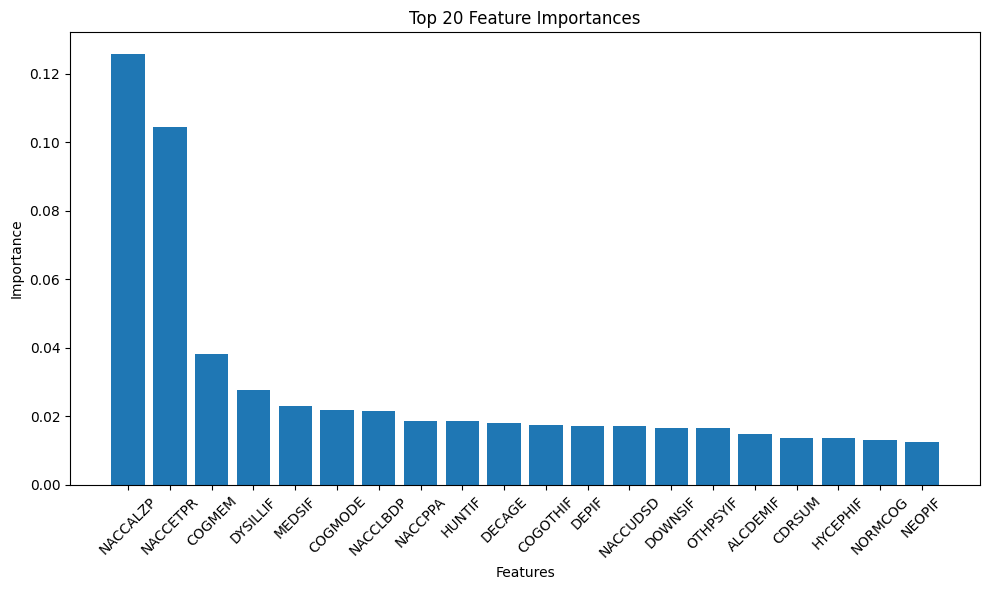

In [104]:
TOP_K = 20
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a list of (importance, feature) tuples
feature_importance_tuples = [(importance, feature) for importance, feature in zip(feature_importances, feature_names)]

# Sort the tuples by importance in descending order
feature_importance_tuples.sort(reverse=True)

# Display the top 10 most important features
print(f"Top {TOP_K} most important features:")
for importance, feature in feature_importance_tuples[:TOP_K]:
    print(f"{feature}: {importance:.4f}")
    
# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.bar([feature[1] for feature in feature_importance_tuples[:TOP_K]], [feature[0] for feature in feature_importance_tuples[:TOP_K]])
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title(f'Top {TOP_K} Feature Importances')
plt.tight_layout()
plt.show()

In [105]:
import shap
# Initialize SHAP explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test[:100])

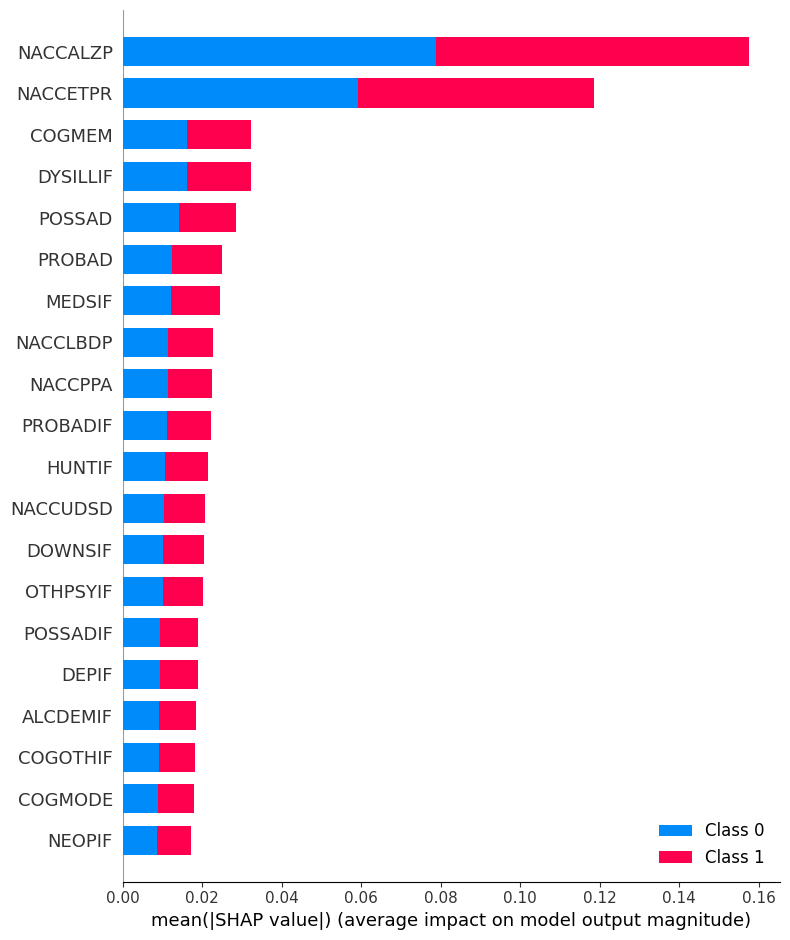

In [106]:
shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names, plot_type="bar", max_display = TOP_K)
# shap.summary_plot(shap_values[0], X_test[:100], feature_names=feature_names, plot_type="bar", max_display = 100)
# shap.summary_plot(shap_values[1], X_test[:100], feature_names=feature_names, plot_type="bar", max_display = 100)

In [107]:
from sklearn.ensemble import RandomForestClassifier
"""
feature_names = X_z_score.columns  
label_name= Y_encoded.columns[0]
features = X_z_score.values
labels = Y_encoded.values.reshape(-1)
"""

leak_columns = ['NACCETPR', 'NACCALZP', 'PROBAD', 'PROBADIF', 'POSSAD', 'POSSADIF', 'NACCADMD']
print(X_z_score.shape)
X_ = X_z_score.copy()
X_.drop(leak_columns, axis=1, inplace=True)
print(X_.shape)

feature_names = X_.columns
features = X_.values
label_name= Y_encoded.columns[0]
label = Y_encoded.values

df = pd.concat([X_, Y_encoded], axis=1)
print(df.shape)
# RACE White - 1 SEX Male - 1 Female - 2

(25368, 818)
(25368, 811)
(25368, 812)


Accuracy: 0.9641308632242807
Sensitivity (Recall): 0.9502050380785003
Specificity: 0.9711909711909712
F1 Score: 0.9468768242848804
ROC AUC: 0.9606980046347358
False Positive Rate: 0.02880902880902881
False Negative Rate: 0.04979496192149968
Confusion Matrix: [[3270   97]
 [  85 1622]]
Top 20 most important features:
NACCLBDP: 0.0433
NACCUDSD: 0.0329
MEDSIF: 0.0279
NACCLBDE: 0.0271
ALCDEMIF: 0.0240
NACCPPA: 0.0235
COGOTH3F: 0.0218
FRSTCHG: 0.0218
NACCBVFT: 0.0215
OTHPSYIF: 0.0212
DEMENTED: 0.0182
BRNINJIF: 0.0180
COGMEM: 0.0179
PSPIF: 0.0162
DEPIF: 0.0160
COGOTH2F: 0.0158
CDRGLOB: 0.0156
COURSE: 0.0156
COGOTHIF: 0.0150
NORMCOG: 0.0150


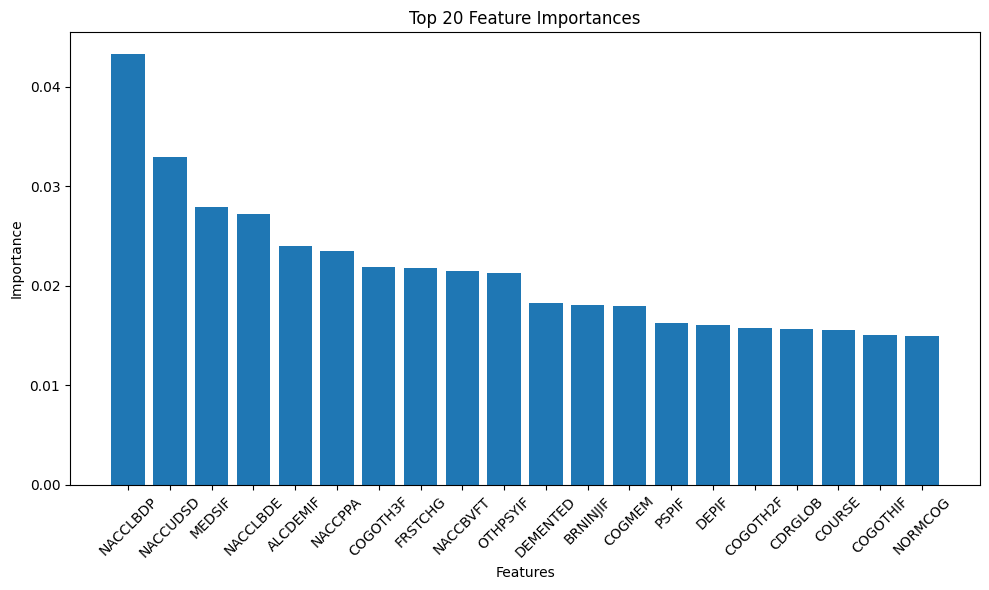

In [108]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=7)
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)
y_pred = rf_model.predict(X_test)
metrics = calculate_classification_metrics(y_test, y_pred)

for metric, value in metrics.items():
    print(f"{metric}: {value}")
TOP_K = 20
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a list of (importance, feature) tuples
feature_importance_tuples = [(importance, feature) for importance, feature in zip(feature_importances, feature_names)]

# Sort the tuples by importance in descending order
feature_importance_tuples.sort(reverse=True)

# Display the top 10 most important features
print(f"Top {TOP_K} most important features:")
for importance, feature in feature_importance_tuples[:TOP_K]:
    print(f"{feature}: {importance:.4f}")
    
# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.bar([feature[1] for feature in feature_importance_tuples[:TOP_K]], [feature[0] for feature in feature_importance_tuples[:TOP_K]])
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title(f'Top {TOP_K} Feature Importances')
plt.tight_layout()
plt.show()

In [109]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

df['SEX'] = df['SEX'].astype(int)
df['RACE'] = df['RACE'].astype(int)
print(df['SEX'].value_counts())
print(df['RACE'].value_counts())
dataset = StandardDataset(df, 
                          label_name='NACCALZD', 
                          favorable_classes=[1], 
                          protected_attribute_names=['SEX','RACE'], 
                          privileged_classes=[[0.0],[0.0]])



 0    14933
-1    10435
Name: SEX, dtype: int64
0     25140
7       170
15       58
Name: RACE, dtype: int64


In [110]:
from IPython.display import Markdown, display
from collections import defaultdict


def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)

def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 1)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [111]:
(dataset_train,
 dataset_val,
 dataset_test) = dataset.split([0.5, 0.8], shuffle=True)

SEX = 0
RACE = 1
sens_ind = RACE # 0-SEX 1-RACE 决定对于哪个敏感变量进行测试
sens_attr = dataset_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_train.privileged_protected_attributes[sens_ind]]
def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs


In [112]:
describe(dataset_train, dataset_val, dataset_test)

#### Training Dataset shape

(12684, 811)


#### Validation Dataset shape

(7610, 811)


#### Test Dataset shape

(5074, 811)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['SEX', 'RACE']


#### Privileged and unprivileged protected attribute values

[array([0.]), array([0.])] [array([-1.]), array([15.,  7.])]


#### Dataset feature names

['NACCADC', 'FORMVER', 'VISITMO', 'VISITDAY', 'VISITYR', 'NACCVNUM', 'NACCAVST', 'NACCNVST', 'NACCDAYS', 'NACCFDYS', 'NACCREAS', 'NACCREFR', 'BIRTHMO', 'BIRTHYR', 'SEX', 'HISPANIC', 'HISPOR', 'RACE', 'RACESEC', 'RACETER', 'PRIMLANG', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'INBIRMO', 'INBIRYR', 'INSEX', 'NEWINF', 'INHISP', 'INHISPOR', 'NACCNINR', 'INRACE', 'INRASEC', 'INRATER', 'INEDUC', 'INRELTO', 'INKNOWN', 'INLIVWTH', 'INVISITS', 'INCALLS', 'INRELY', 'NACCFAM', 'NACCMOM', 'NACCDAD', 'NACCAM', 'NACCAMS', 'NACCFM', 'NACCFMS', 'NACCOM', 'NACCOMS', 'NACCFADM', 'NACCFFTD', 'ANYMEDS', 'TOBAC30', 'TOBAC100', 'SMOKYRS', 'PACKSPER', 'QUITSMOK', 'ALCOCCAS', 'ALCFREQ', 'CVHATT', 'HATTMULT', 'HATTYEAR', 'CVAFIB', 'CVANGIO', 'CVBYPASS', 'CVPACDEF', 'CVPACE', 'CVCHF', 'CVANGINA', 'CVHVALVE', 'CVOTHR', 'CBSTROKE', 'STROKMUL', 'NACCSTYR', 'CBTIA', 'TIAMULT', 'NACCTIYR', 'PD', 'PDYR', 'PDOTHR', 'PDOTHRYR', 'SEIZURES', 'NACCTBI', 'TBI', 'TBIBRIEF', 'TRAUMBRF', 'TBIEXTEN', 'T

In [113]:
# Explainers
from aif360.explainers import MetricTextExplainer
metric_dataset_train = BinaryLabelDatasetMetric(
        dataset_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer__train = MetricTextExplainer(metric_dataset_train)

print(explainer__train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.562915857033504


train LR

In [114]:
# Scalers
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
dataset = dataset_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_NACC = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

val LR

In [115]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_val,
                   model=lr_NACC,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

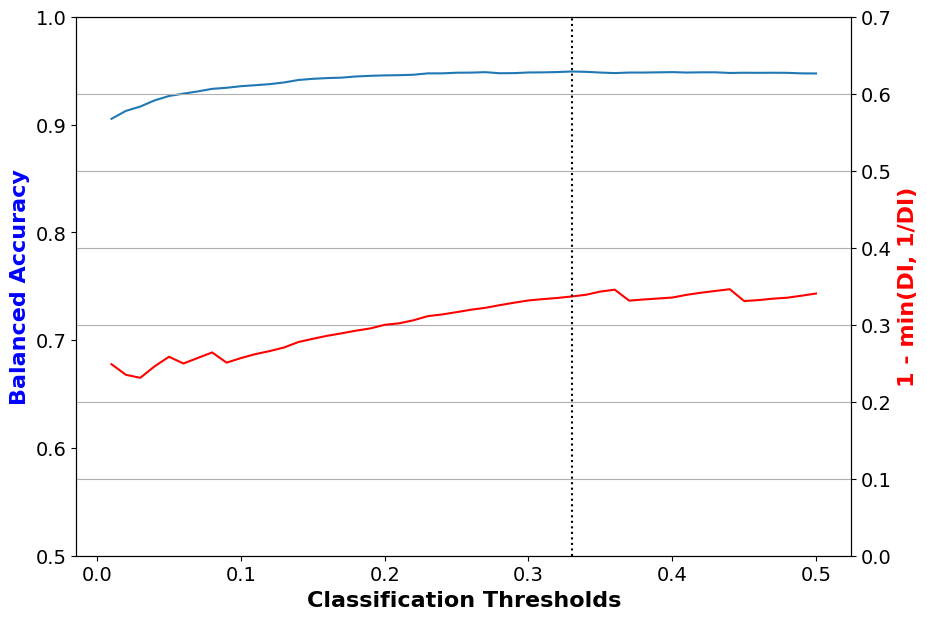

In [116]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

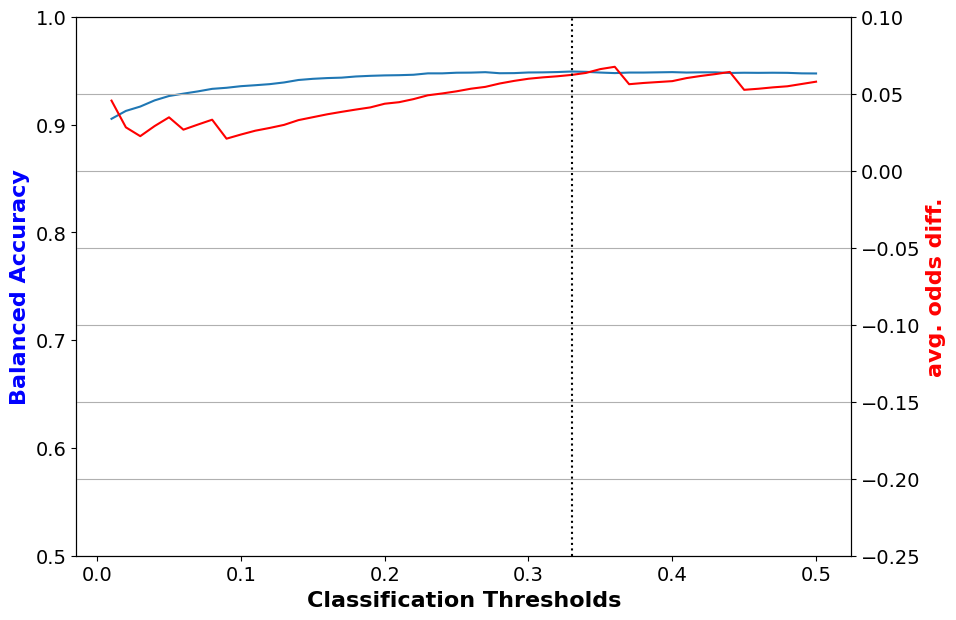

In [117]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [118]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.3300
Best balanced accuracy: 0.9492
Corresponding 1-min(DI, 1/DI) value: 0.3367
Corresponding average odds difference value: 0.0622
Corresponding statistical parity difference value: 0.1820
Corresponding equal opportunity difference value: -0.0170
Corresponding Theil index value: 0.0283


test LR

In [119]:
lr_orig_metrics = test(dataset=dataset_test,
                       model=lr_NACC,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])
describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])                  

Threshold corresponding to Best balanced accuracy: 0.3300
Best balanced accuracy: 0.9484
Corresponding 1-min(DI, 1/DI) value: 0.2964
Corresponding average odds difference value: 0.0334
Corresponding statistical parity difference value: 0.1517
Corresponding equal opportunity difference value: -0.0527
Corresponding Theil index value: 0.0296


In [120]:
# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing, LFR
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_train)
metric_transf_train = BinaryLabelDatasetMetric(
        dataset_transf_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_train = MetricTextExplainer(metric_transf_train)

# lfr = LFR(unprivileged_groups=unprivileged_groups,
#                 privileged_groups=privileged_groups)
# dataset_lfr_train = lfr.fit_transform(dataset_train)
# metric_lfr_train = BinaryLabelDatasetMetric(
#         dataset_lfr_train,
#         unprivileged_groups=unprivileged_groups,
#         privileged_groups=privileged_groups)
# explainer_lfr_train = MetricTextExplainer(metric_lfr_train)

print(explainer_transf_train.disparate_impact())
# print(explainer_lfr_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9999999999999997


train RW LR

In [121]:
dataset = dataset_transf_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf_NACC = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

y_pred = lr_transf_NACC.predict(dataset_test.features)
metrics = calculate_classification_metrics(dataset_test.labels.ravel(), y_pred)


val RW LR

Threshold corresponding to Best balanced accuracy: 0.3400
Best balanced accuracy: 0.9493
Corresponding 1-min(DI, 1/DI) value: 0.3212
Corresponding average odds difference value: 0.0505
Corresponding statistical parity difference value: 0.1693
Corresponding equal opportunity difference value: -0.0162
Corresponding Theil index value: 0.0284


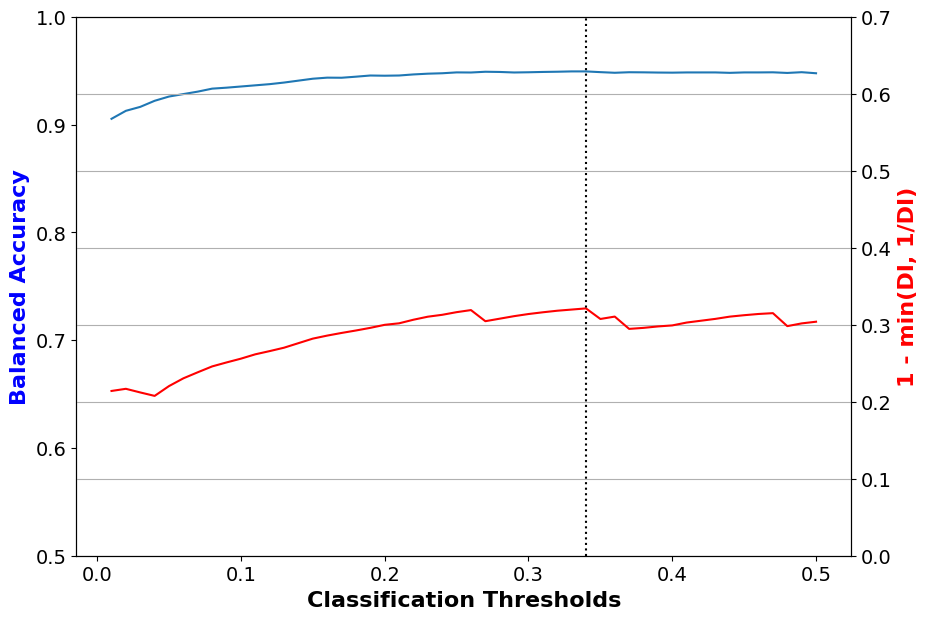

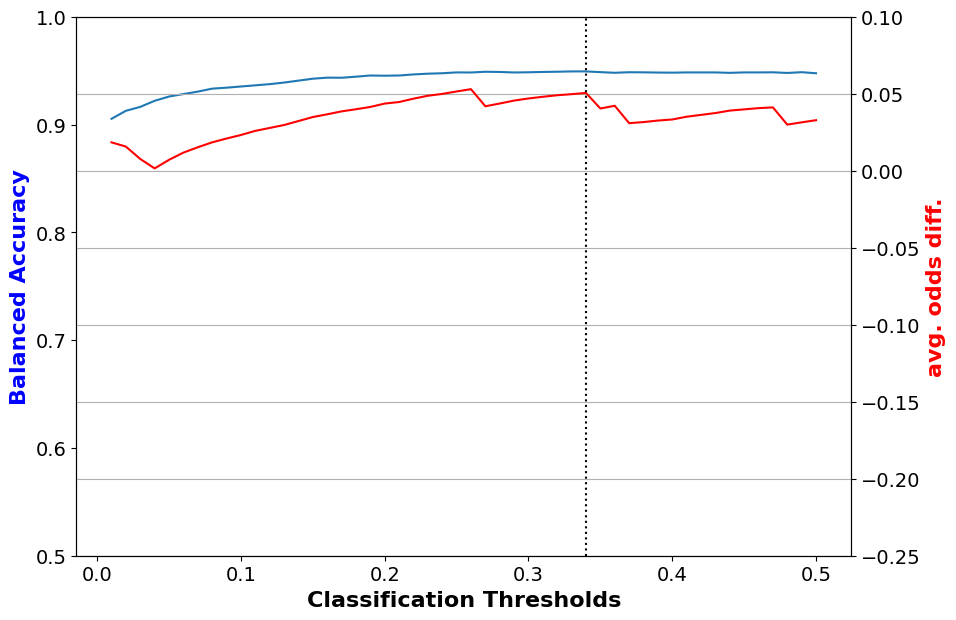

In [122]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_val,
                   model=lr_transf_NACC,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

describe_metrics(val_metrics, thresh_arr)

test RW LR

In [123]:
lr_transf_metrics = test(dataset=dataset_test,
                         model=lr_transf_NACC,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])
describe_metrics(lr_transf_metrics, [thresh_arr[lr_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.3400
Best balanced accuracy: 0.9491
Corresponding 1-min(DI, 1/DI) value: 0.2274
Corresponding average odds difference value: -0.0097
Corresponding statistical parity difference value: 0.1057
Corresponding equal opportunity difference value: -0.0527
Corresponding Theil index value: 0.0293


train RF

In [124]:
dataset = dataset_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_NACC = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

val RF

Threshold corresponding to Best balanced accuracy: 0.6014
Best balanced accuracy: 0.9399
Corresponding 1-min(DI, 1/DI) value: 0.2896
Corresponding average odds difference value: 0.0256
Corresponding statistical parity difference value: 0.1370
Corresponding equal opportunity difference value: 0.0188
Corresponding Theil index value: 0.0368


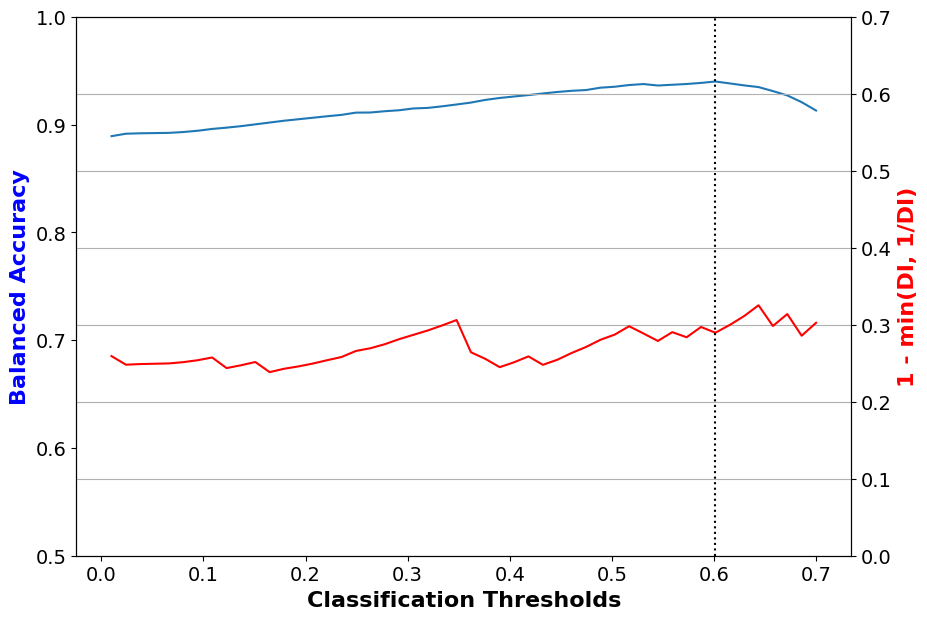

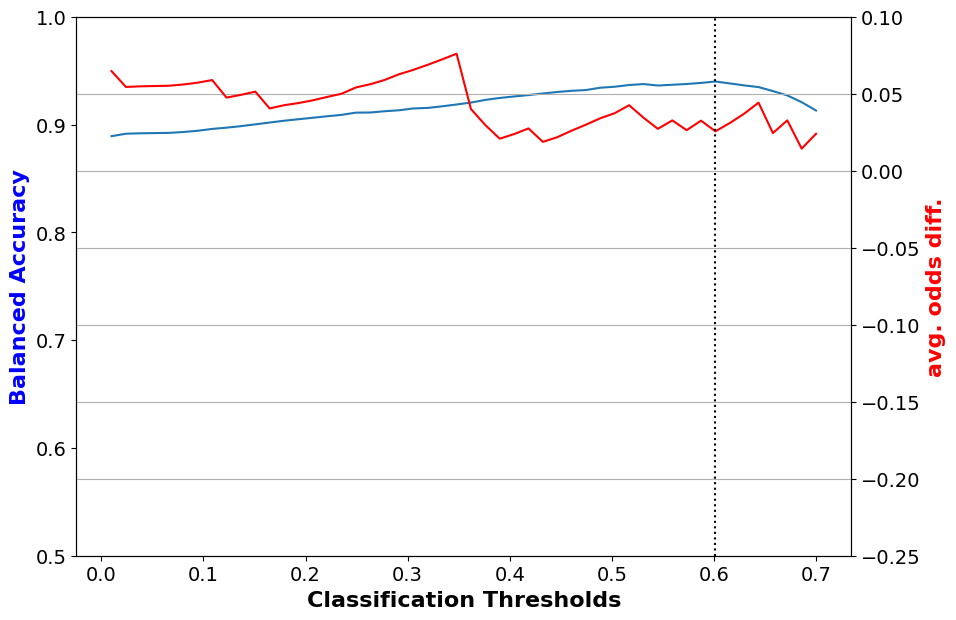

In [138]:
thresh_arr = np.linspace(0.01, 0.7, 50)
val_metrics = test(dataset=dataset_val,
                   model=rf_NACC,
                   thresh_arr=thresh_arr)
rf_orig_best_ind = np.argmax(val_metrics['bal_acc'])

disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

describe_metrics(val_metrics, thresh_arr)

test RF

In [126]:
rf_orig_metrics = test(dataset=dataset_test,
                       model=rf_NACC,
                       thresh_arr=[thresh_arr[rf_orig_best_ind]])
describe_metrics(rf_orig_metrics, [thresh_arr[rf_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.5000
Best balanced accuracy: 0.9304
Corresponding 1-min(DI, 1/DI) value: 0.3098
Corresponding average odds difference value: 0.0573
Corresponding statistical parity difference value: 0.1729
Corresponding equal opportunity difference value: -0.0544
Corresponding Theil index value: 0.0367


In [127]:
# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_train)
metric_transf_train = BinaryLabelDatasetMetric(
        dataset_transf_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_train = MetricTextExplainer(metric_transf_train)

print(explainer_transf_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9999999999999997


train RW RF

In [128]:
dataset = dataset_transf_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_transf_NACC = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

val RW RF

Threshold corresponding to Best balanced accuracy: 0.5873
Best balanced accuracy: 0.9382
Corresponding 1-min(DI, 1/DI) value: 0.3193
Corresponding average odds difference value: 0.0467
Corresponding statistical parity difference value: 0.1596
Corresponding equal opportunity difference value: 0.0164
Corresponding Theil index value: 0.0373


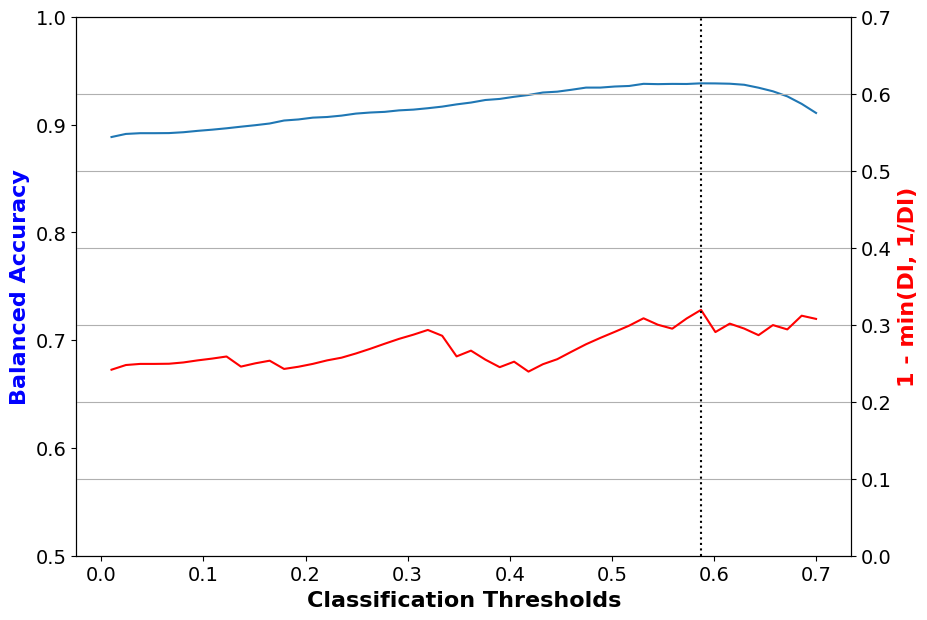

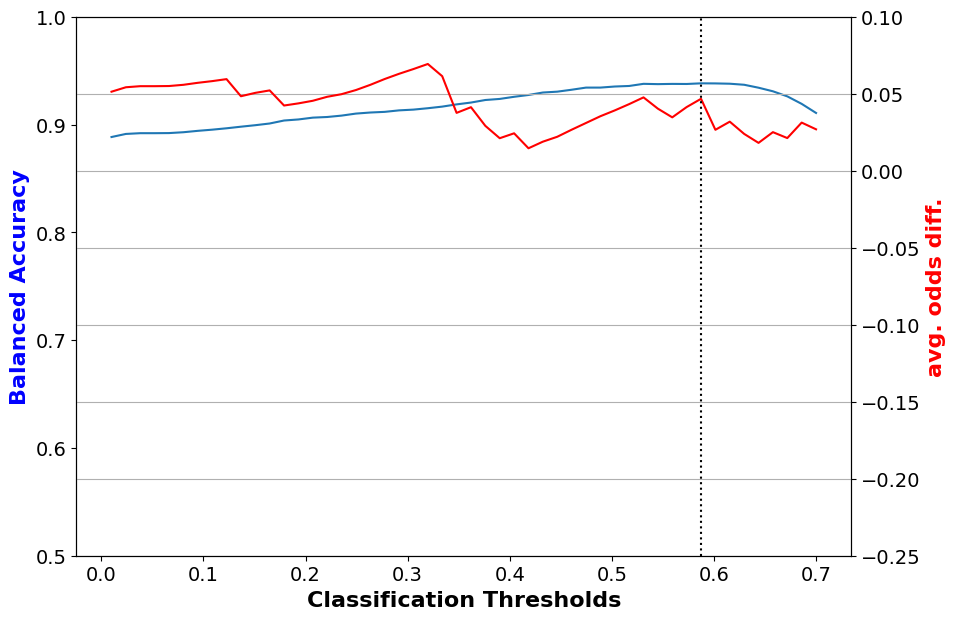

In [137]:
thresh_arr = np.linspace(0.01, 0.7, 50)
val_metrics = test(dataset=dataset_val,
                   model=rf_transf_NACC,
                   thresh_arr=thresh_arr)
rf_transf_best_ind = np.argmax(val_metrics['bal_acc'])

disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')
describe_metrics(val_metrics, thresh_arr)

test RF after Reweighing

In [130]:
rf_transf_metrics = test(dataset=dataset_test,
                         model=rf_transf_NACC,
                         thresh_arr=[thresh_arr[rf_transf_best_ind]])
describe_metrics(rf_transf_metrics, [thresh_arr[rf_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.5000
Best balanced accuracy: 0.9307
Corresponding 1-min(DI, 1/DI) value: 0.3395
Corresponding average odds difference value: 0.0801
Corresponding statistical parity difference value: 0.1974
Corresponding equal opportunity difference value: -0.0538
Corresponding Theil index value: 0.0367


inprocessing

In [131]:
from aif360.algorithms.inprocessing import PrejudiceRemover
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
pr_orig_scaler = StandardScaler()

dataset = dataset_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)

pr_NACC = model.fit(dataset)

thresh_arr = np.linspace(0.01, 0.50, 50)
##val
dataset = dataset_val.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

val_metrics = test(dataset=dataset,
                   model=pr_NACC,
                   thresh_arr=thresh_arr)
pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

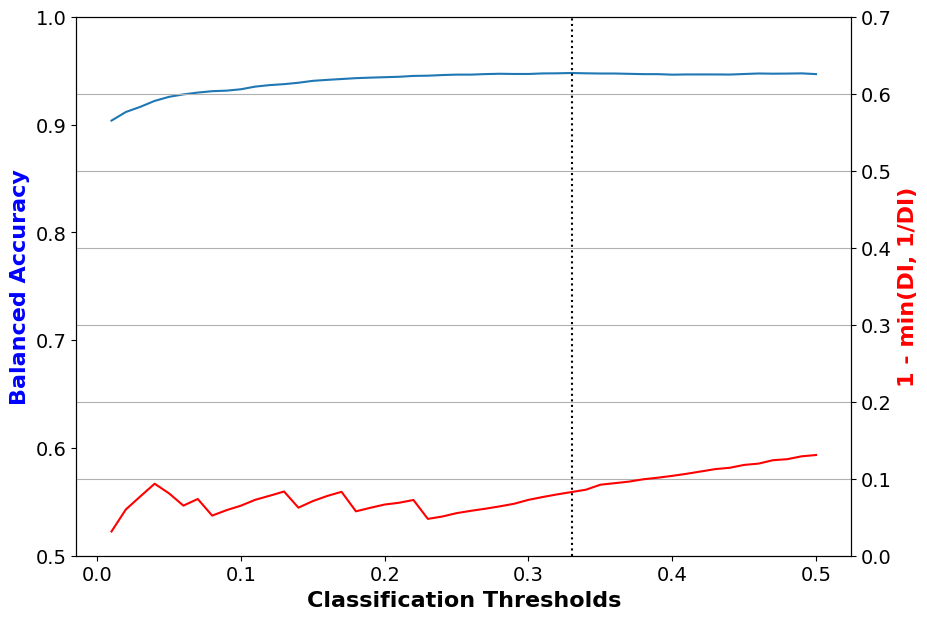

In [132]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

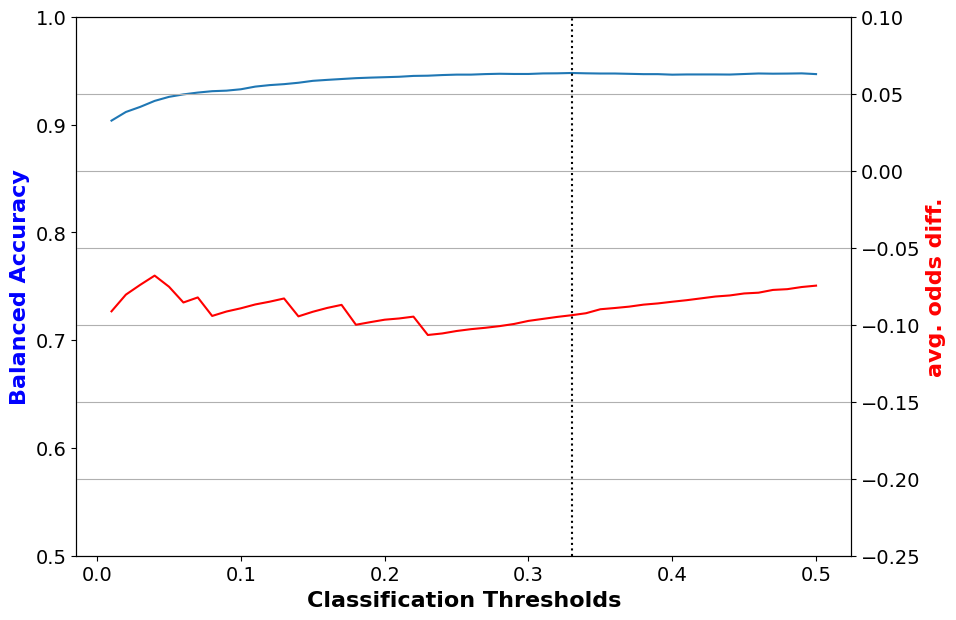

In [133]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [134]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.3300
Best balanced accuracy: 0.9478
Corresponding 1-min(DI, 1/DI) value: 0.0827
Corresponding average odds difference value: -0.0938
Corresponding statistical parity difference value: 0.0324
Corresponding equal opportunity difference value: -0.2531
Corresponding Theil index value: 0.0292


In [135]:
##Test PR
dataset = dataset_test.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

pr_orig_metrics = test(dataset=dataset,
                       model=pr_NACC,
                       thresh_arr=[thresh_arr[pr_orig_best_ind]])
describe_metrics(pr_orig_metrics, [thresh_arr[pr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.3300
Best balanced accuracy: 0.9457
Corresponding 1-min(DI, 1/DI) value: 0.1657
Corresponding average odds difference value: -0.1906
Corresponding statistical parity difference value: -0.0600
Corresponding equal opportunity difference value: -0.4544
Corresponding Theil index value: 0.0312


In [139]:
import pandas as pd
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, rf_orig_metrics, lr_transf_metrics,
           rf_transf_metrics, pr_orig_metrics]
debias = pd.Series(['']*2 + ['Reweighing']*2
                 + ['Prejudice Remover'],
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression', 'Random Forest']*2 + [''],
                name='Classifier')
result = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])
#save pandas dataframe to csv
result.to_csv('result.csv')


In [ ]:
result

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
,Logistic Regression,0.950348,0.016355,1.349688,0.107879,-0.006146,0.027287
,Random Forest,0.923268,0.042870,1.426481,0.134369,0.003641,0.040965
Reweighing,Logistic Regression,0.950101,0.005824,1.315906,0.097353,-0.016522,0.027944
Reweighing,Random Forest,0.926197,0.035132,1.396840,0.125160,0.002496,0.039727
Prejudice Remover,,0.935285,0.006111,1.315697,0.099672,-0.031396,0.035699
